# The CAQL Processing Model

We start with a few remarks about the processing model, that will help you to reason about CAQL easily.
It helps to set expectations about the possibilities of the language and explains behavior that might seem odd, at first sight.

## CAQL is a Stream Processing Language

We want the language to be used for alerting so stream processing is the primary focus.
This is in contrast to batch processing, where data is stored in a database and available for fetching.

The principal building blocks of CAQL are Processing Units, that take a number of input streams as _slot arguments_, and produce a number of output streams.


![CAQL Processing Units](img/pu_intro.png)

## Each Processing Unit is a State Machine

![StateMachine](img/pu.png)

Processing units maintain internal state, which changes over time.
The state transition form time $t-1$ to time $t$ is computed at time $t$,
and depends on the incoming data streams.

The last input values we have seen before $t$ are $y_{t-1}[1],y_{t-1}[N]$.
We don't have information about samples that arrive for the time window starting at `t`.
So the computation of $z_t$ can only involve samples up to $y_{t-1}$.

This is the reason why data in CAQL checks appears to be one period behind the original data.

When showing CAQL queries on graphs we correct for this effect, by shifting the data by 1M into the future.

## CAQL for Batch Processing

There are some important applicatsions that can not be implemented with a stream processing model.
The simplest example is averages over the currently active window.
At the time the window starts, we can't say what the average over it is going to be.

Nevertheless, we want to be able to support queries like this in CAQL.


, that do not follow a stream processing paradigm.
The foremost example is `top(k)`

# Processing units can be composed

![PUCompuse](img/pu_compose.png)

The power of CAQL lies in it's capability to compose processing units into larger stream processors.
The individual processing units are rather simple, but the compound processor can realize complex behavior.

## CAQL Syntax

![](img/pu_syntax.png)

- CAQL functions get compiled into processing units
- CAQL functions have arguments and slots
- arguments configure the processing unit (e.g. `delay(1M)`)
- slots specify the plumbing of processing units.

The example above might be generated by a CAQL expression:

```
pu_3(){ pu_1(){A, B, C}, pu_2(){D, E} }
```

## Pipe Composition

Most of the time we are building linear sequences of processing units, e.g.

![](img/pu_pipe.png)

With the above syntax this would look like this:

```
delay(1h){ rolling:mean(1h){ ... } }
```

An equivalent way to formulate this query is:

```
... | rolling:mean(1h) | delay()
```


This syntax is lended from shell programming, were we are plumbing processes with UNIX pipes.
What happens under the hood is, that whatever stands before the pipe is inserted as first argument to the function that comes after the pipe:

A() + B() | C() <=> C(){ A() + B() }

Pipes have the lowest precedence among the binary CAQL operators.

> Pipes are syntactic sugar for first argument insertion.

## CAQL operates on rolled-up data

* Each input value $y_t$ represents a rollup aggregate on a time window from $t$ (inclusive) to $t+period$ (exclusive).

* The current rollup period is 1M.

* Supported value types are numbers and histograms (circllhist)

**TODO:** Support smaller rollup periods in CAQL.

## Output Aggregation

* CAQL Processing always takes place at the working period of 1M.
* If data with higher periods is requested from CAQL the aggregation happens at end.
* CAQL aggregates numeric data by averaging.

**TODO**: Support different output aggregation methods (min/max/pX)

## Rollup Optimization I

**CAVEAT:** In order to serve queries over long time intervals (e.g. 1y), we have to process large amounts of 1M data (e.g. 525K values per metric).

**OPTIMIZATION:** There are some cases where optimizations can be applied, to speed up processing.
E.g. when requesting the following query over 1y will a period of 1d:

```search:metric:average(...) | stats:mean()```

We get the same result by either:

- Pulling 1y of 1M data for each metric, applyig stats:mean() over each 1M interval, averaging to 1d values.
- Pulling 1y of 1d data, applying stats:mean() over the period=1d data.

The latter version is much faster, and is used for graphing.

## Rollup Optimization II

There are other cases, where this optimization is not possible, e.g.

```search:metric:average(...) | stats:max()```

Here the results are (drastically) different, between:

- Calculating maxima over 1d averages, and
- Calculating 1d-averages over 1M maximas.

Workarounds:

* By using the [#preview](https://login.circonus.com/resources/docs/user/caql_reference.html#Advancedcompositionwithslotarguments) directive you can force CAQL to operate on higher rollup data. This will be much faster but differ from your expectations.

* To get accurate results with high read performance, you can persist the results in the DB by creating a CAQL Check. The backfill function will allow you to insert data up to 1y in the past.

In [17]:
%run preamble.py
%matplotlib inline

Text(0.5,1,'Preview')

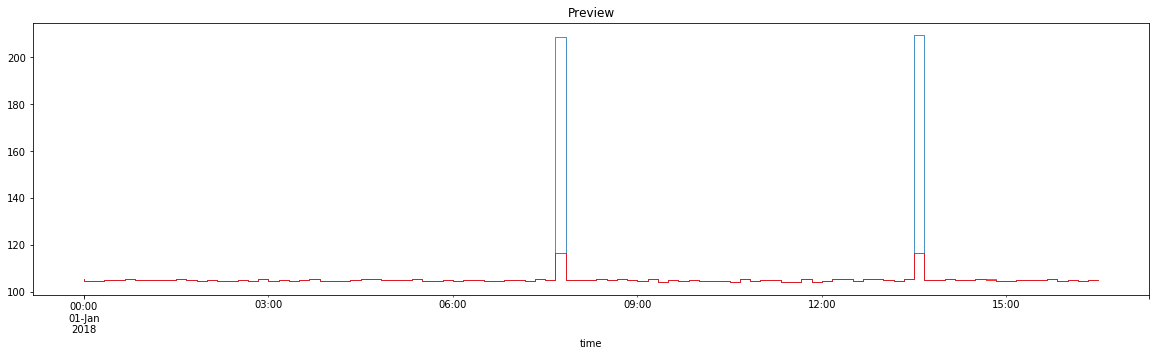

In [23]:
ax=caql_plot('demo','''
search:metric:average("duration") | stats:max()
''', datetime(2018,1,1), 600, 100)
plt.title("Normal")
caql_plot('demo','''
#preview
search:metric:average("duration") | stats:max()
''', datetime(2018,1,1), 600, 100, ax=ax, color="red")
plt.title("Preview")

## Customizing Rollup Functions

**CAVEAT:** Aggregation is always performed by mean value.

**TODO:** Support other aggregation functions (e.g. max).

**WORKAROUND:** There is an documented VIEW_PERIOD variable, that allows you to cusomize the effective rollup mechanisms by using windowing functions, e.g. `| window:max(VIEW_PERIOD)`.
